# Data Import

In [17]:
import pymysql
import pandas as pd

db_config = {
    "host": "34.57.190.250",
    "user": "root",
    "password": "20020418",
    "database": "movies",
    "port": 3306,
}

def fetch_data(limit=10000, random_sample=False):
    base_query = """
    SELECT 
        ur.rating_id,
        ur.user_id,
        ur.movie_id,
        ur.rating,
        m.title,
        m.release_date,
        m.budget,
        m.revenue,
        m.runtime,
        m.popularity,
        m.vote_average,
        m.vote_count,
        GROUP_CONCAT(DISTINCT g.genre_name) AS genres,
        GROUP_CONCAT(DISTINCT c.name) AS cast_names,
        GROUP_CONCAT(DISTINCT cr.name) AS crew_names
    FROM UserRatings ur
    LEFT JOIN Movies m ON ur.movie_id = m.movie_id
    LEFT JOIN MovieGenres mg ON m.movie_id = mg.movie_id
    LEFT JOIN Genres g ON mg.genre_id = g.genre_id
    LEFT JOIN MovieCast mc ON m.movie_id = mc.movie_id
    LEFT JOIN Cas c ON mc.cast_id = c.cast_id
    LEFT JOIN MovieCrew mcr ON m.movie_id = mcr.movie_id
    LEFT JOIN Crew cr ON mcr.crew_id = cr.crew_id
    GROUP BY ur.rating_id
    """
    if random_sample:
        base_query += " HAVING RAND() < 0.1"
    base_query += f" LIMIT {limit};"
    try:
        connection = pymysql.connect(**db_config)
        print("Database connection successful!")
        df = pd.read_sql(base_query, connection)
        print(f"Data retrieved successfully! Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    finally:
        connection.close()
    return df

def main():
    limit = 5000
    random_sample = False
    df = fetch_data(limit=limit, random_sample=random_sample)
    print("Column names:", df.columns.tolist())
    print("Descriptive statistics:")
    print(df.describe(include='all'))
    return df


if __name__ == "__main__":
    df = main()


Database connection successful!


/var/folders/t8/78l36wb51dxf9t_qkrhc0pc00000gn/T/ipykernel_14332/3266892418.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(base_query, connection)


Data retrieved successfully! Rows: 5000, Columns: 15
Column names: ['rating_id', 'user_id', 'movie_id', 'rating', 'title', 'release_date', 'budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count', 'genres', 'cast_names', 'crew_names']
Descriptive statistics:
           rating_id user_id movie_id       rating    title release_date  \
count   5.000000e+03    5000     5000  5000.000000     5000         5000   
unique           NaN     303      370          NaN      369          365   
top              NaN    6697      150          NaN  48 Hrs.   1982-12-07   
freq             NaN     102      206          NaN      206          206   
mean    8.324665e+08     NaN      NaN     3.524200      NaN          NaN   
std     1.216232e+06     NaN      NaN     1.022362      NaN          NaN   
min     8.255829e+08     NaN      NaN     1.000000      NaN          NaN   
25%     8.318056e+08     NaN      NaN     3.000000      NaN          NaN   
50%     8.325815e+08     NaN      NaN  

# Data Cleaning

In [21]:
def clean_data(df):
    # Fill missing values in string columns
    df['genres'].fillna('Unknown', inplace=True)
    df['cast_names'].fillna('', inplace=True)
    df['crew_names'].fillna('', inplace=True)
    
    # Replace zeros in budget and revenue with NaN
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df.loc[df['budget'] == 0, 'budget'] = pd.NA
    df.loc[df['revenue'] == 0, 'revenue'] = pd.NA
    
    # Fill NaN values with median
    df['budget'].fillna(df['budget'].median(), inplace=True)
    df['revenue'].fillna(df['revenue'].median(), inplace=True)
    
    # Convert release_date to datetime and extract release_year
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date'].dt.year
    df.drop(columns=['release_date'], inplace=True)
    
    # One-hot encode genres
    genres_dummies = df['genres'].str.get_dummies(sep=',')
    df = pd.concat([df, genres_dummies], axis=1)
    df.drop(columns=['genres'], inplace=True)
    
    # Normalize numeric columns
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    numeric_columns = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    # Truncate cast_names and crew_names to top 10
    df['cast_names'] = df['cast_names'].apply(
        lambda x: ', '.join(x.split(', ')[:10]) if isinstance(x, str) else ''
    )
    df['crew_names'] = df['crew_names'].apply(
        lambda x: ', '.join(x.split(', ')[:10]) if isinstance(x, str) else ''
    )
    
    # Drop low-importance columns
    df.drop(columns=['cast_names', 'crew_names'], inplace=True)
    
    return df


df_cleaned = clean_data(df)
print("Cleaned DataFrame columns:", df_cleaned.columns.tolist())
print("Cleaned descriptive statistics:")
print(df_cleaned.describe(include='all'))

Cleaned DataFrame columns: ['rating_id', 'user_id', 'movie_id', 'rating', 'title', 'budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count', 'release_year', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']
Cleaned descriptive statistics:
           rating_id user_id movie_id       rating    title       budget  \
count   5.000000e+03    5000     5000  5000.000000     5000  5000.000000   
unique           NaN     303      370          NaN      369          NaN   
top              NaN    6697      150          NaN  48 Hrs.          NaN   
freq             NaN     102      206          NaN      206          NaN   
mean    8.324665e+08     NaN      NaN     3.524200      NaN     0.135237   
std     1.216232e+06     NaN      NaN     1.022362      NaN     0.195845   
min     8.255829e+08     NaN      NaN     1.000000      NaN 

# Visualization

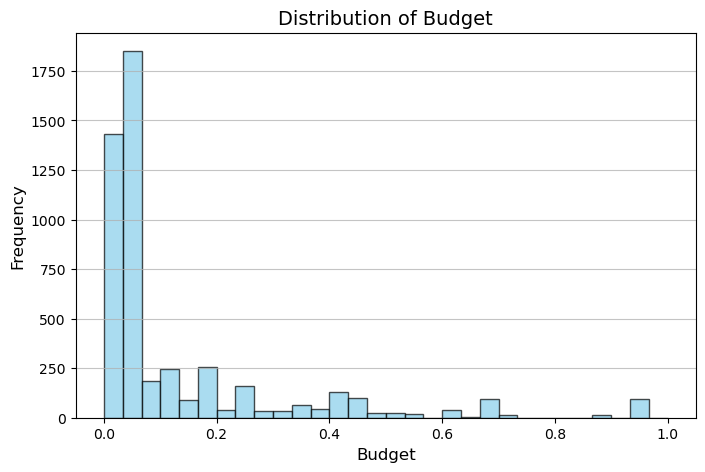

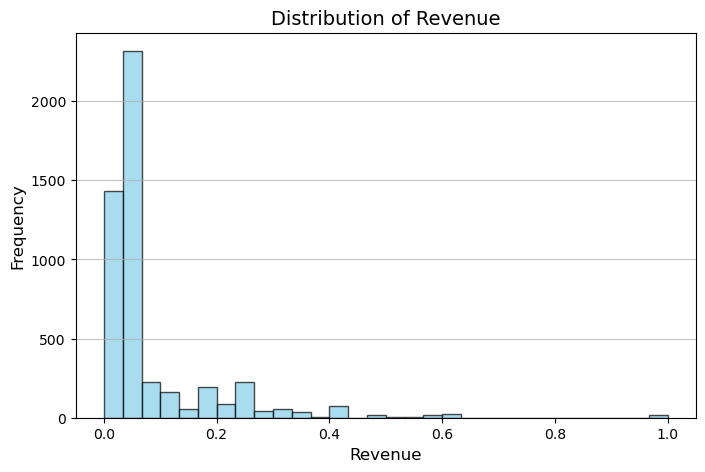

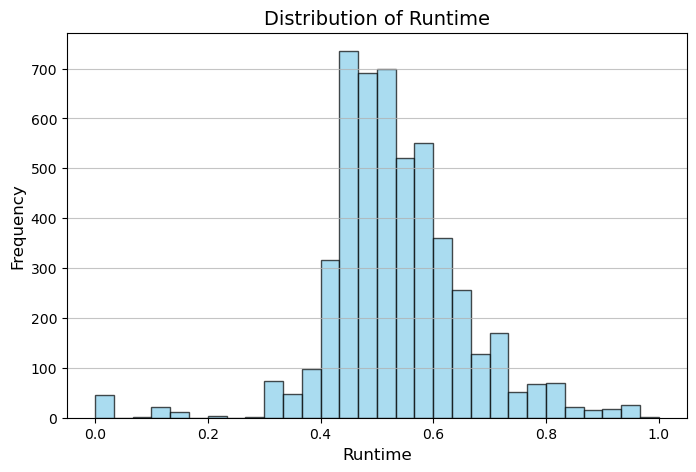

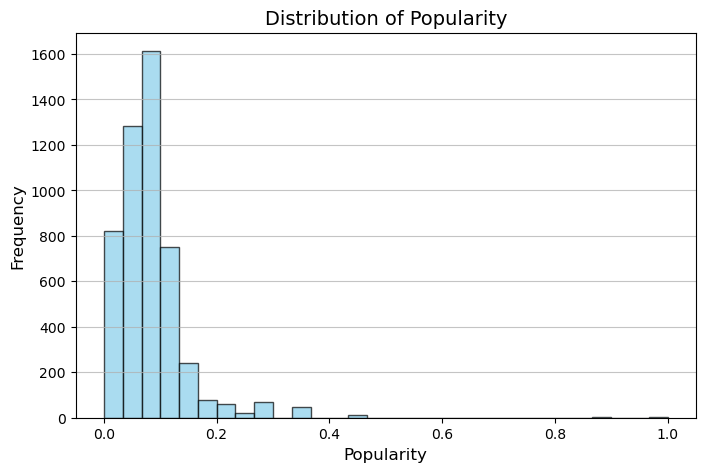

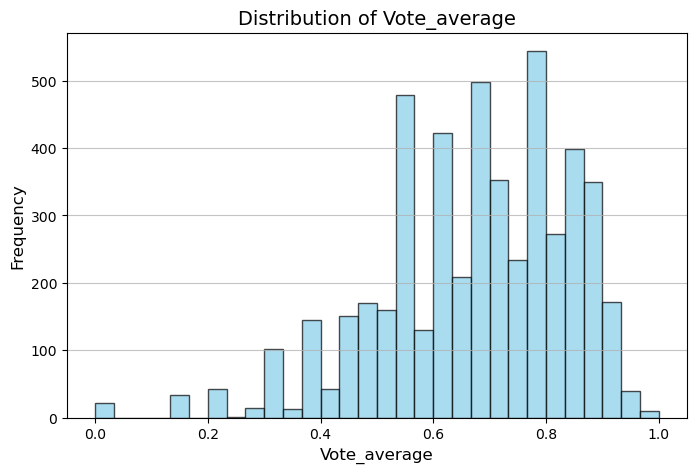

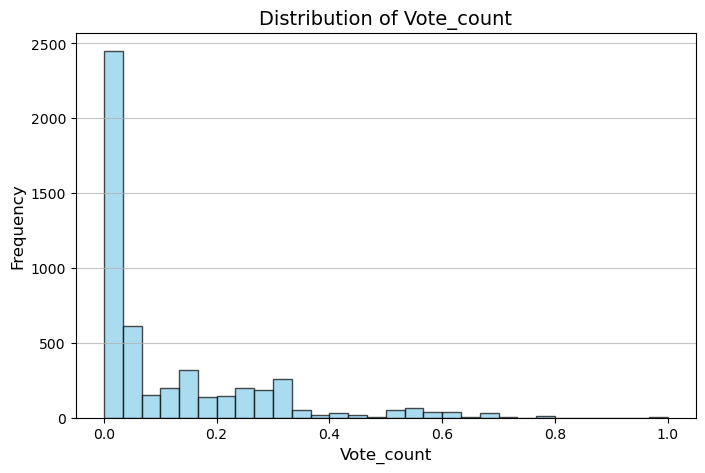

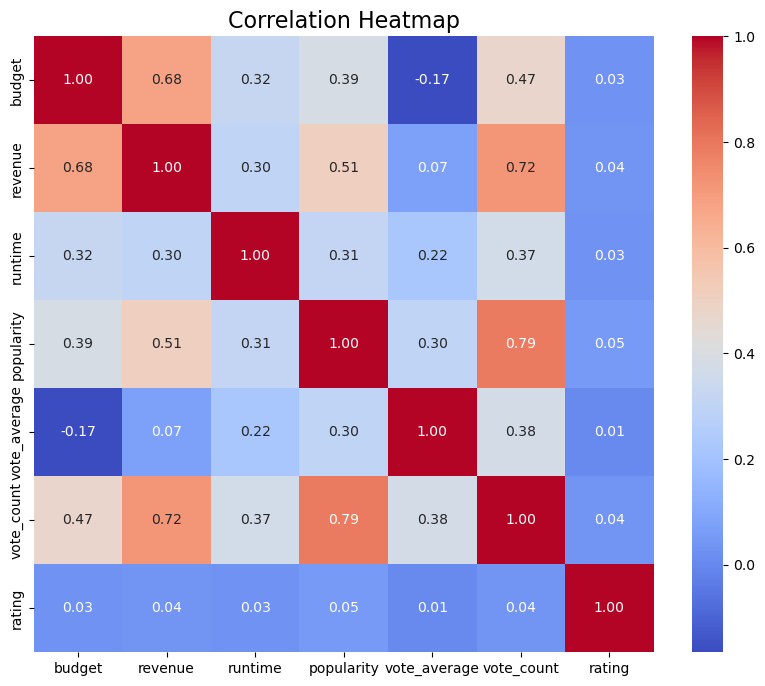

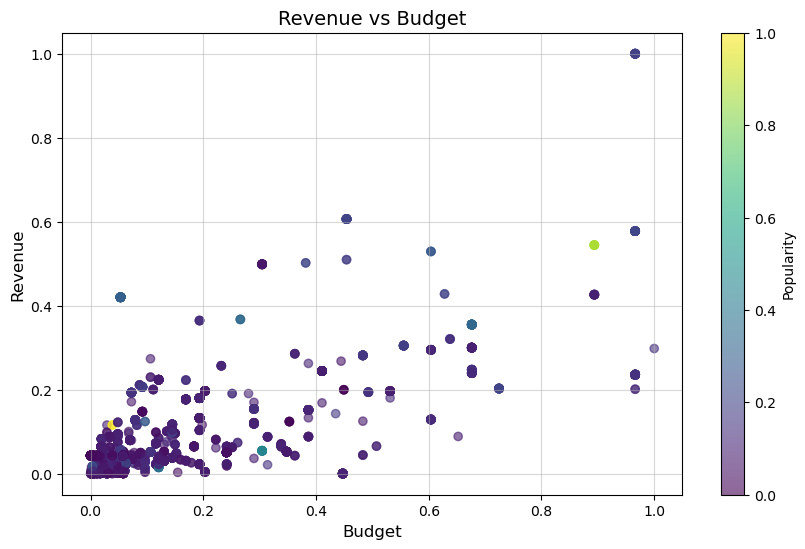

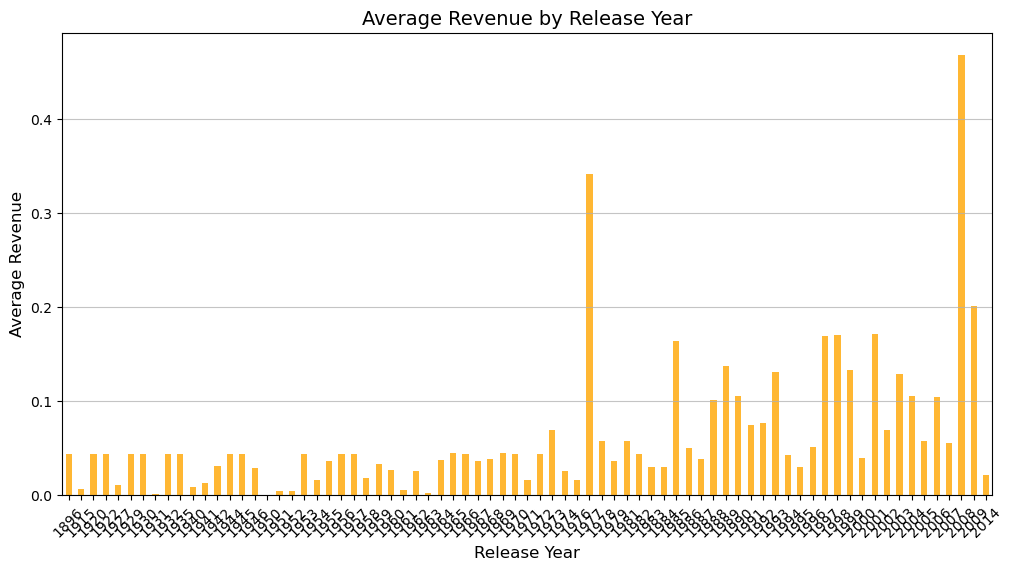

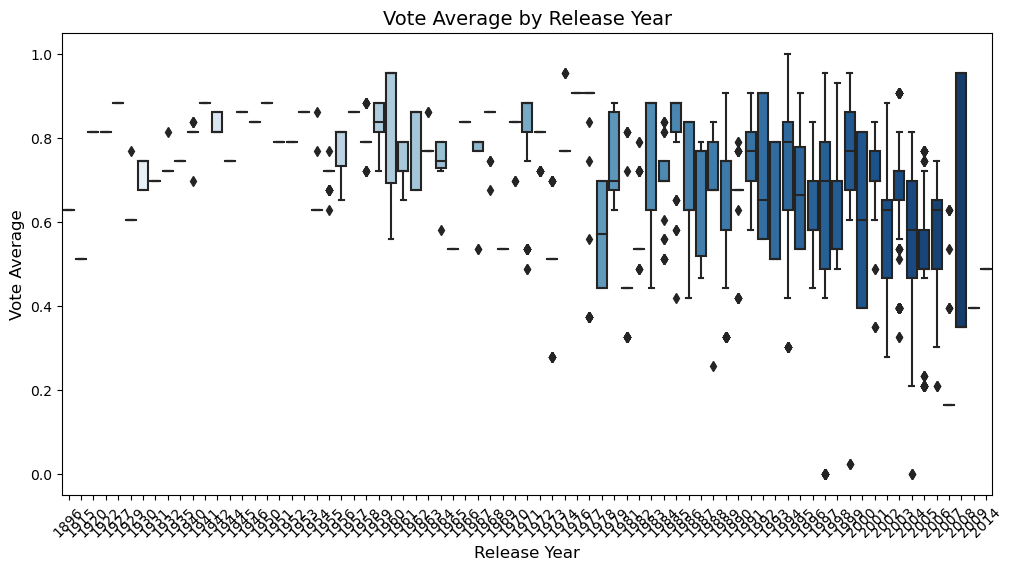

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Numeric Features
for column in ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']:
    plt.figure(figsize=(8, 5))
    plt.hist(df_cleaned[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column.capitalize()}', fontsize=14)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation = df_cleaned[['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count',"rating"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# 3. Revenue vs Budget Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['budget'], df_cleaned['revenue'], alpha=0.6, c=df_cleaned['popularity'], cmap='viridis')
plt.colorbar(label='Popularity')
plt.title('Revenue vs Budget', fontsize=14)
plt.xlabel('Budget', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# 4. Average Revenue by Release Year
avg_revenue_year = df_cleaned.groupby('release_year')['revenue'].mean()

plt.figure(figsize=(12, 6))
avg_revenue_year.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Average Revenue by Release Year', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

# 5. Boxplot for Vote Average by Release Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='release_year', y='vote_average', data=df_cleaned, palette='Blues')
plt.title('Vote Average by Release Year', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Vote Average', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# Model

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature selection
wide_features = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
                 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
                 'Thriller', 'War', 'Western']
deep_features = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count', 'release_year']

# Data preparation
X_wide = df_cleaned[wide_features].values
X_deep = df_cleaned[deep_features].values
y = df_cleaned['rating'].values

# Data standardization
scaler = StandardScaler()
X_deep = scaler.fit_transform(X_deep)

# Train-test split
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide, X_deep, y, test_size=0.2, random_state=42
)

# Model definition
def build_model2():
    wide_inputs = tf.keras.layers.Input(shape=(len(wide_features),))
    wide = tf.keras.layers.Dense(1, activation=None)(wide_inputs)

    deep_inputs = tf.keras.layers.Input(shape=(len(deep_features),))
    deep = tf.keras.layers.Dense(128, activation='relu')(deep_inputs)
    deep = tf.keras.layers.Dense(64, activation='relu')(deep)
    deep = tf.keras.layers.Dense(1, activation=None)(deep)

    both = tf.keras.layers.concatenate([wide, deep])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    
    model = tf.keras.models.Model(inputs=[wide_inputs, deep_inputs], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Model training
model = build_model2()
history = model.fit(
    [X_wide_train, X_deep_train], y_train,
    validation_data=([X_wide_test, X_deep_test], y_test),
    epochs=20,
    batch_size=32
)

# Model evaluation
loss, mse = model.evaluate([X_wide_test, X_deep_test], y_test)
print(f"Test Loss: {loss}, Test Mean Squared Error: {mse}")

# Predictions
predictions = model.predict([X_wide_test, X_deep_test])


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 9.2696 - mean_squared_error: 9.2696 - val_loss: 7.3403 - val_mean_squared_error: 7.3403
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 7.4246 - mean_squared_error: 7.4246 - val_loss: 7.3127 - val_mean_squared_error: 7.3127
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 7.4680 - mean_squared_error: 7.4680 - val_loss: 7.3088 - val_mean_squared_error: 7.3088
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 7.3581 - mean_squared_error: 7.3581 - val_loss: 7.3076 - val_mean_squared_error: 7.3076
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 7.6297 - mean_squared_error: 7.6297 - val_loss: 7.3070 - val_mean_squared_error: 7.3070
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 7.4621 - mean_squared_error: 7.4621 - val_loss: 7.3067 - val_mean_squared_error: 7.3067
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 7.4892 - mean_squared_error: 7.4892 - 

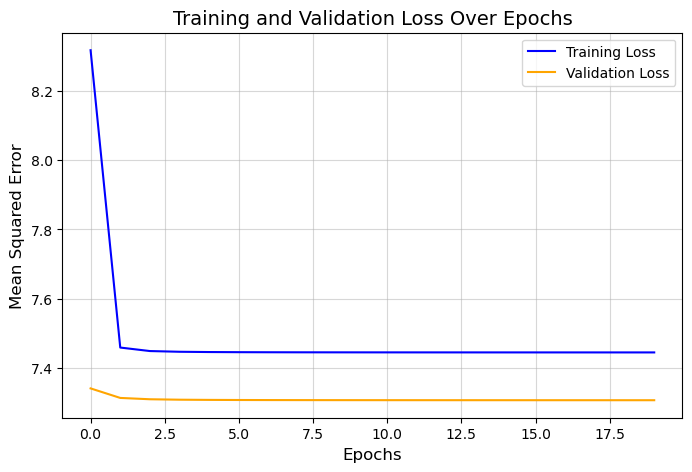

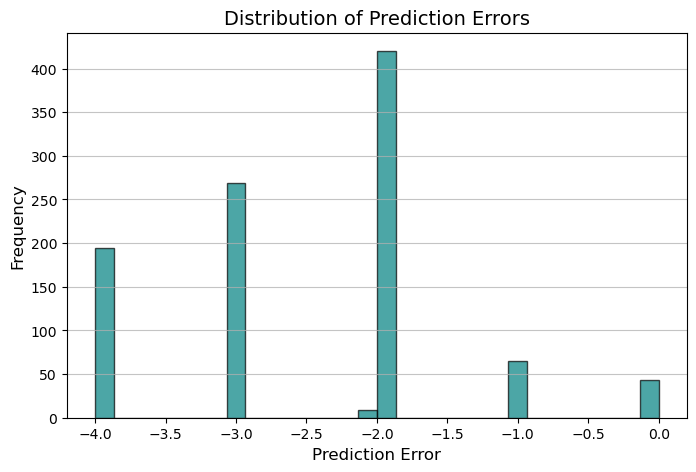

In [30]:
# 1. Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# 2. Distribution of prediction errors
errors = predictions.flatten() - y_test
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()